# STAT778: Final Project

In [1]:
import numpy as np
from numpy.random import uniform, normal, multivariate_normal, exponential
import scipy as sc
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#it's not quite this. 3.2 does some sort of learning. how?
#we're measuring the likelihood (via the pdf) of x given our parameters and the result.
#THEN we combine that with our prior.
#Then we have a posterior belief about how possible these parameters are given the data we just saw and our prior belief.
#now we binarize this belief stochastically! and move onto the next iteration.

## Metropolis-Hastings with a Bayesian Linear Model

In [3]:
#metropolis-hastings functions
def sample(data: np.ndarray, N: int, B: int, start_theta: tuple, search_breadth: float=1):
    """Takes N samples via the Metropolis-Hastings algorithm, with B burn-in samples."""
    theta = start_theta
    for b in range(B): #burnin samples
        results = step(data, theta, search_breadth)
        theta = results['theta']
    
    samples = []
    for n in range(N): #real samples
        results = step(data, theta, search_breadth)
        theta = results['theta']
        samples.append(results)
    return samples

def step(data: np.ndarray, theta: tuple, search_breadth: float):
    """Takes one step in the Metropolis-Hastings algorithm by generating a new theta and comparing to a given theta."""
    theta_prime = sample_theta(theta, search_breadth) #sample a new set of parameters
    acceptance_probability = min(1,calc_acceptance_prob(theta, theta_prime, data, search_breadth)) #calculate the probability of acceptance
    accepted = acceptance_probability >= uniform() #probabilistically determine acceptance 
    return {'accepted': accepted, 'acceptance_prob': acceptance_probability, 'theta': theta_prime if accepted else theta} #return results, update theta if samples accepted

def sample_theta(theta: tuple, search_breadth: float=1):
    """Samples theta parameters--slope, intercept, and standard deviation."""
    a,b,sigma = theta
    a,b = multivariate_normal([a,b], [[search_breadth**2,0],[0,search_breadth**2]])
    sigma = exponential(sigma*search_breadth)
    theta = a,b,sigma
    return theta

def calc_acceptance_prob(theta: tuple, theta_prime: tuple, data: np.ndarray, search_breadth: float):
    """Calculates acceptance probability by using a Bayesian linear model."""
    theta_likelihood = likelihood(theta, data)
    theta_prior = prior(theta)
    
    theta_p_likelihood = likelihood(theta_prime, data)
    theta_p_prior = prior(theta_prime)
    
    acceptance_ratio = (theta_p_likelihood/theta_likelihood) * ((theta_p_prior/theta_prior) * proposal_ratio(theta, theta_prime))
    return acceptance_ratio

#bayesian functions
def likelihood(theta: tuple, data: np.ndarray):
    """Calculates the likelihood component of our linear model by measuring our parameters theta on the given data."""
    a,b,sigma = theta
    x,y = data[0],data[1]
    likelihoods = sc.stats.norm.pdf(y, loc=a*x+b, scale=sigma) #find the likelihood of a sample given a normal distribution specified by our parameters and the data
    return np.prod(likelihoods) #use log likelihood for stability

def prior(theta):
    """Calculates the prior component of our linear model, specified """
    a,b,sigma = theta
    a_prob, b_prob = sc.stats.multivariate_normal.pdf([a,b]) #cov defaults to 1
    sigma_prob = sc.stats.expon.pdf(sigma)
    return np.prod([a_prob,b_prob,sigma_prob])

def proposal_ratio(theta: tuple, theta_prime: tuple):
    """Offsets bidirectionality of chained samples."""
    a,b,sigma = theta
    a_p,b_p,sigma_p = theta_prime
    old_given_new = sc.stats.multivariate_normal.pdf([a,b],[a_p,b_p])*sc.stats.expon.pdf(sigma)
    new_given_old = sc.stats.multivariate_normal.pdf([a_p,b_p],[a,b])*sc.stats.expon.pdf(sigma_p)
    return old_given_new/new_given_old

## Zero Case: N(0,1)

In [4]:
X = np.random.rand(10000)
Y = np.random.normal(0,1,10000)
data = np.vstack((X,Y))
samples = sample(data, 30000, 0, (0,0,1), 1)
df = pd.DataFrame(samples)
df[['a','b','sigma']] = pd.DataFrame(df['theta'].tolist(), index=df.index)
df = df.drop(['theta'], axis=1)

<ipython-input-3-083a8b270b4d>:39: RuntimeWarning: invalid value encountered in double_scalars
  acceptance_ratio = (theta_p_likelihood/theta_likelihood) * ((theta_p_prior/theta_prior) * proposal_ratio(theta, theta_prime))
c:\users\seans\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\_continuous_distns.py:243: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\users\seans\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\_distn_infrastructure.py:1835: RuntimeWarning: overflow encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
c:\users\seans\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\_distn_infrastructure.py:1835: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
<ipython-input-3-083a8b270b4d>:39: RuntimeWarning: divide by zero encountered in double_scalars
  acceptance_ratio = (theta_p_likelihood/theta_lik

In [5]:
df

,accepted,acceptance_prob,a,b,sigma
0,True,1,-0.306207,1.276395,0.409391
1,True,1,-1.494236,2.154405,0.061962
2,True,1,-2.903248,1.274130,0.307792
3,True,1,-3.121005,0.624000,0.053262
4,True,1,-2.298845,0.646869,0.055776
...,...,...,...,...,...
29995,True,1,-34.112871,59.717570,0.000000
29996,True,1,-33.783409,59.938307,0.000000
29997,True,1,-33.562590,61.057936,0.000000
29998,True,1,-34.201456,64.108216,0.000000


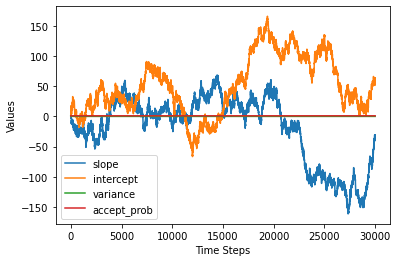

In [6]:
plt.plot(range(len(df)),df['a'], label='slope')
plt.plot(range(len(df)),df['b'], label='intercept')
plt.plot(range(len(df)),df['sigma'], label='variance')
plt.plot(range(len(df)),df['acceptance_prob'], label='accept_prob')
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()

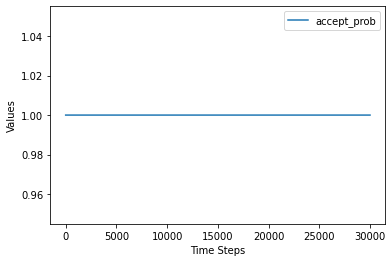

In [7]:
plt.plot(range(len(df)),df['acceptance_prob'], label='accept_prob')
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()

## Nonzero Case: N(4,2)

In [8]:
X = np.random.rand(100)
Y = np.random.normal(4,2,100)
data = np.vstack((X,Y))
samples = sample(data, 30000, 0, (0,0,1), 1)
df = pd.DataFrame(samples)
df[['a','b','sigma']] = pd.DataFrame(df['theta'].tolist(), index=df.index)
df = df.drop(['theta'], axis=1)

<ipython-input-3-083a8b270b4d>:39: RuntimeWarning: invalid value encountered in double_scalars
  acceptance_ratio = (theta_p_likelihood/theta_likelihood) * ((theta_p_prior/theta_prior) * proposal_ratio(theta, theta_prime))
c:\users\seans\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\_continuous_distns.py:243: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
<ipython-input-3-083a8b270b4d>:39: RuntimeWarning: divide by zero encountered in double_scalars
  acceptance_ratio = (theta_p_likelihood/theta_likelihood) * ((theta_p_prior/theta_prior) * proposal_ratio(theta, theta_prime))
c:\users\seans\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\_distn_infrastructure.py:1835: RuntimeWarning: overflow encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
c:\users\seans\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\_distn_infrastructure.py:1835: RuntimeWarning: divide by 

In [9]:
df
#it accepts every single one?
#does it arrive to the right parameters?
#effect of changing starting point?

,accepted,acceptance_prob,a,b,sigma
0,True,1,1.117637,-2.066014,0.925730
1,True,1,1.369187,-3.628229,1.544043
2,True,1,2.274410,-5.656103,0.010658
3,True,1,1.997607,-5.819791,0.002489
4,True,1,1.476286,-6.374748,0.001010
...,...,...,...,...,...
29995,True,1,-174.538004,167.148085,0.000000
29996,True,1,-173.789841,165.255433,0.000000
29997,True,1,-174.289741,164.673169,0.000000
29998,True,1,-174.589670,164.541562,0.000000


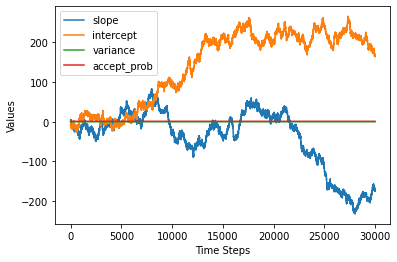

In [10]:
plt.plot(range(len(df)),df['a'], label='slope')
plt.plot(range(len(df)),df['b'], label='intercept')
plt.plot(range(len(df)),df['sigma'], label='variance')
plt.plot(range(len(df)),df['acceptance_prob'], label='accept_prob')
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()

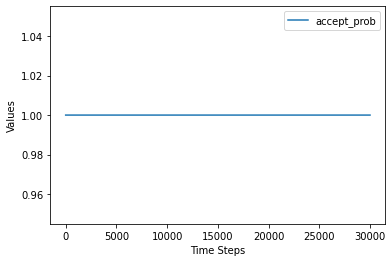

In [11]:
plt.plot(range(len(df)),df['acceptance_prob'], label='accept_prob')
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()

## The Larger Case: N(50, 5)

In [12]:
X = np.random.rand(100)
Y = np.random.normal(4,2,100)
data = np.vstack((X,Y))
samples = sample(data, 30000, 0, (0,0,1), 1)
df = pd.DataFrame(samples)
df[['a','b','sigma']] = pd.DataFrame(df['theta'].tolist(), index=df.index)
df = df.drop(['theta'], axis=1)

<ipython-input-3-083a8b270b4d>:39: RuntimeWarning: divide by zero encountered in double_scalars
  acceptance_ratio = (theta_p_likelihood/theta_likelihood) * ((theta_p_prior/theta_prior) * proposal_ratio(theta, theta_prime))


In [13]:
df

,accepted,acceptance_prob,a,b,sigma
0,True,1.000000e+00,0.031937,0.033922,1.288999
1,True,1.000000e+00,0.877649,-0.994294,4.020019
2,False,0.000000e+00,0.877649,-0.994294,4.020019
3,False,1.841073e-11,0.877649,-0.994294,4.020019
4,False,2.313331e-08,0.877649,-0.994294,4.020019
...,...,...,...,...,...
29995,False,0.000000e+00,-0.297912,3.865490,1.933603
29996,False,6.300834e-02,-0.297912,3.865490,1.933603
29997,False,7.621753e-15,-0.297912,3.865490,1.933603
29998,False,9.559716e-22,-0.297912,3.865490,1.933603


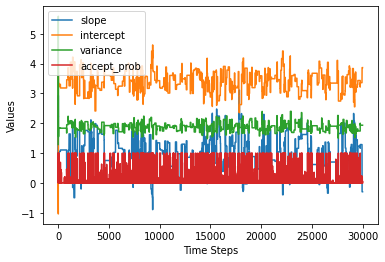

In [14]:
plt.plot(range(len(df)),df['a'], label='slope')
plt.plot(range(len(df)),df['b'], label='intercept')
plt.plot(range(len(df)),df['sigma'], label='variance')
plt.plot(range(len(df)),df['acceptance_prob'], label='accept_prob')
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()

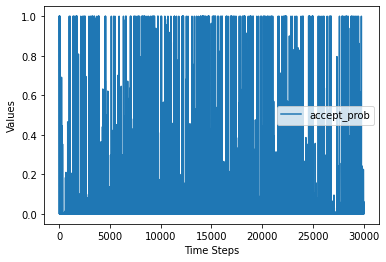

In [15]:
plt.plot(range(len(df)),df['acceptance_prob'], label='accept_prob')
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()

## NFL Data

In [25]:
#per https://gist.github.com/Deryck97/dff8d33e9f841568201a2a0d5519ac5e
YEAR = 2023
nfl_df = pd.read_csv('https://github.com/nflverse/nflverse-data/releases/download/pbp/' \
                   'play_by_play_' + str(YEAR) + '.csv.gz',
                   compression= 'gzip', low_memory= False)

In [27]:
nfl_df[nfl_df['epa'].isna()]['desc']

90       END QUARTER 2
174           END GAME
251      END QUARTER 2
341           END GAME
416      END QUARTER 2
             ...      
49282         END GAME
49371    END QUARTER 2
49457         END GAME
49538    END QUARTER 2
49664         END GAME
Name: desc, Length: 570, dtype: object

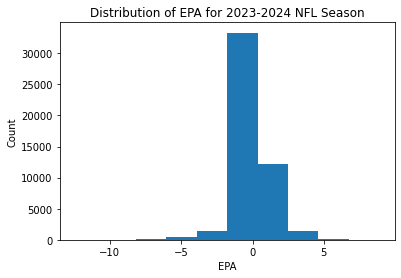

In [29]:
plt.hist(nfl_df['epa'])
plt.xlabel('EPA')
plt.ylabel('Count')
plt.title('Distribution of EPA for 2023-2024 NFL Season')
plt.savefig('plots/epa_distr_2023.png')